In [1]:
from gurobipy import *
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import os
import pickle

### target image

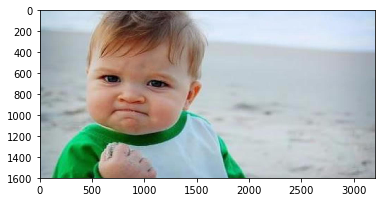

In [3]:
target_image = io.imread(r'C:\Users\LG\Pictures\target_image.jpg')
target_image = cv2.resize(target_image, (3200,1600), interpolation=cv2.INTER_AREA)
plt.imshow(target_image)
plt.show()

### basis image (korean identification image 296)

In [5]:
basis_images = []
basis_size = 64
f_jpg = glob.glob(os.path.join(r'C:\Users\LG\Pictures\google_iphoto\new\crop', "*.jpg"))
for file in f_jpg:
    img = io.imread(file)
    img = cv2.resize(img, (basis_size,basis_size), interpolation=cv2.INTER_AREA)
    basis_images.append(img)    
    
basis_images = np.array(basis_images)
print( "basis image dimension :", basis_images[0,:,:,:].shape)
print( "basis image number:", basis_images.shape[0])

basis image dimension : (64, 64, 3)
basis image number: 296


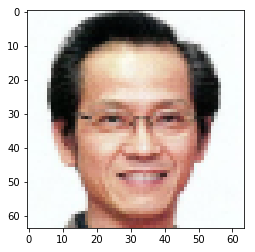

In [5]:
plt.imshow(basis_images[0,:,:,:])
plt.show()

In [7]:
(ncol, nrow)=np.array(target_image.shape[:2])//basis_size
n_basis = basis_images.shape[0]

## 1. use loop
#### 1) absolute mean difference for RGB channel   (  e.g. sum(abs(mean difference of 3 channel)))

In [9]:
mosaic_image = np.zeros_like(target_image)
solution = np.zeros((ncol,nrow))
b = basis_size
for i in range(ncol):
    for j in range(nrow):
        target_mean= np.mean(target_image[b*i:b*(i+1),b*j:b*(j+1),:], axis=(0,1))
        mean_diff= abs(basis_mean-target_mean)
        basis_number= np.argmin(np.sum(mean_diff, axis=1))
        mosaic_image[b*i:b*(i+1),b*j:b*(j+1),:] = basis_images[basis_number,:,:,:]
        solution[i,j] = basis_number

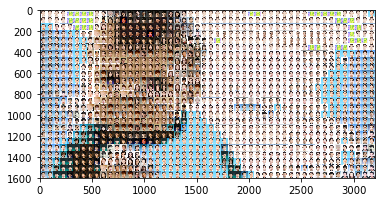

In [10]:
plt.imshow(mosaic_image)
plt.show()

### 2) pixel absolute difference

In [138]:
mosaic_image = np.zeros_like(target_image)
solution = np.zeros((ncol,nrow))
b = basis_size
for i in range(ncol):
    for j in range(nrow):
        target= np.zeros((1, b, b, 3))
        target[0,:,:,:]= target_image[b*i:b*(i+1),b*j:b*(j+1),:]
        abs_diff= abs(basis_images-target)
        basis_number= np.argmin(np.sum(abs_diff, axis=(1,2,3)))
        mosaic_image[b*i:b*(i+1),b*j:b*(j+1),:] = basis_images[basis_number,:,:,:]
        solution[i,j] = basis_number

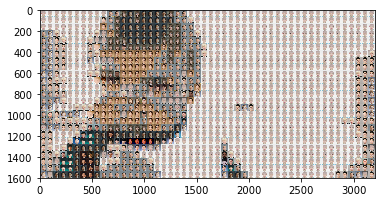

In [139]:
plt.imshow(mosaic_image)
plt.show()

## 2. use package
### use mean difference
#### Optimization Model

$\text{minimize}:\qquad\sum_{y=1}^{nrow}\sum_{x=1}^{ncol}\sum_{c=R,G,B}~~error_{xy,c}$

$\text{subject to}:\qquad 1) error_{xy,c}\geq E[x,y,c]$

$\qquad\qquad\qquad 2) error_{xy,c}\geq -E[x,y,c]$

$\qquad\qquad\qquad for, \; c\in\{R,G,B\}, \;\; x=1,...,ncol, \;\; y=1,...,nrow $

$\qquad\qquad\qquad E[x,y,c]=\sum_{j=1}^{basis\,num}(G[x,y,c]-B_j[c])\cdot p_j[x,y] $

$\qquad\qquad\qquad 3) \sum_{j=1}^{s}p_{j}[x,y]=1,\;  p_j[x,y]\in\{0,1\}$

$G[x,y,c] \, $: x,y th target tile's c channel mean value  
$B_j[c] \;\;\;\;\;$ : j th basis image's c channel mean value  
$p_{j}[x,y]\;\;\,$ : 1 if x,y th target tile = j th basis image  (for each target tile only one basis image can be used)  
condition 1),2) is for making linear contraints

In [8]:
basis_mean = np.mean(basis_images, axis=(1,2))

target_mean= np.zeros((ncol, nrow,3))
for i in range(ncol):
    for j in range(nrow):
        target_mean[i,j,:]= np.mean(target_image[basis_size*i:basis_size*(i+1),basis_size*j:basis_size*(j+1),:], axis=(0,1))

In [86]:
m = Model("mosaic")
p = m.addVars(int(ncol),int(nrow),int(n_basis),vtype=GRB.BINARY)
diff = m.addVars(int(ncol),int(nrow),3)

m.setObjective(diff.sum(), GRB.MINIMIZE)

m.addConstrs((p.sum(i,j,'*') == 1 for i in range(ncol) for j in range(nrow)), "sos")
m.addConstrs((diff[i,j,c] >= quicksum(p[i,j,b]*(basis_mean[b,c]-target_mean[i,j,c]) for b in range(n_basis))
              for i in range(ncol) for j in range(nrow) for c in range(3)), "diff1")
m.addConstrs((diff[i,j,c] >= -quicksum(p[i,j,b]*(basis_mean[b,c]-target_mean[i,j,c]) for b in range(n_basis))
              for i in range(ncol) for j in range(nrow) for c in range(3)), "diff2")

m.optimize()

Optimize a model with 8750 rows, 373750 columns and 2597498 nonzeros
Variable types: 3750 continuous, 370000 integer (370000 binary)
Coefficient statistics:
  Matrix range     [2e-04, 2e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 227590
Presolve removed 1440 rows and 31557 columns (presolve time = 5s) ...
Presolve removed 8743 rows and 373451 columns (presolve time = 26s) ...
Presolve removed 8743 rows and 373451 columns
Presolve time: 26.12s
Presolved: 7 rows, 299 columns, 2076 nonzeros
Found heuristic solution: objective 41370.651122
Variable types: 3 continuous, 296 integer (296 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.1291298e+04   1.000769e+00   0.000000e+00     26s
       8    4.1307730e+04   0.000000e+00   0.000000e+00     26s

Root relaxation: objective 4.130773e+04, 8 iterations, 0.02 seconds

    Nodes    |    Cu

In [87]:
solution = m.getAttr('x',p)
solution_basis = np.zeros((ncol,nrow))
a = np.arange(n_basis)
mosaic_image = np.zeros_like(target_image)

for i in range(ncol):
    for j in range(nrow):
        for b in range(n_basis):       
            a[b] = solution[i,j,b]
        mosaic_image[basis_size*i:basis_size*(i+1),basis_size*j:basis_size*(j+1),:] = basis_images[np.argmax(a),:,:,:]
plt.imshow(mosaic_image)
plt.show()

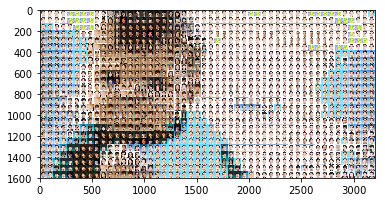

### additional constraints
#### each basis image can be used at most 20 times

#### Optimization Model

$\text{minimize}:\qquad\sum_{y=1}^{nrow}\sum_{x=1}^{ncol}\sum_{c=R,G,B}~~error_{xy,c}$

$\text{subject to}:\qquad 1) error_{xy,c}\geq E[x,y,c]$

$\qquad\qquad\qquad 2) error_{xy,c}\geq -E[x,y,c]$

$\qquad\qquad\qquad for, \; c\in\{R,G,B\}, \;\; x=1,...,ncol, \;\; y=1,...,nrow $

$\qquad\qquad\qquad E[x,y,c]=\sum_{j=1}^{basis\,num}(T[x,y,c]-B_j[c])\cdot p_j[x,y] $

$\qquad\qquad\qquad 3) \sum_{j=1}^{s}p_{j}[x,y]=1,\;  p_j[x,y]\in\{0,1\}$

$\qquad\qquad\qquad 4) \sum_{y=1}^{nrow}\sum_{x=1}^{ncol}p_{j}[x,y]<=20$

condition 4) means each basis image can be used at most 20 times

In [89]:
# modeling and optimize

c = 20 # maximum usage of each basis 
m = Model("mosaic")
p = m.addVars(int(ncol),int(nrow),int(n_basis),vtype=GRB.BINARY)
diff = m.addVars(int(ncol),int(nrow),3)

m.setObjective(diff.sum(), GRB.MINIMIZE)

m.addConstrs((p.sum(i,j,'*') == 1 for i in range(ncol) for j in range(nrow)), "sos")
m.addConstrs((diff[i,j,c] >= quicksum(p[i,j,b]*(basis_mean[b,c]-target_mean[i,j,c]) for b in range(n_basis))
              for i in range(ncol) for j in range(nrow) for c in range(3)), "diff1")
m.addConstrs((diff[i,j,c] >= -quicksum(p[i,j,b]*(basis_mean[b,c]-target_mean[i,j,c]) for b in range(n_basis))
              for i in range(ncol) for j in range(nrow) for c in range(3)), "diff2")
m.addConstrs((p.sum('*','*',b) <= c for b in range(n_basis)), "usage_constraint")

m.optimize()

Optimize a model with 9046 rows, 373750 columns and 2967498 nonzeros
Variable types: 3750 continuous, 370000 integer (370000 binary)
Coefficient statistics:
  Matrix range     [2e-04, 2e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 227590
Presolve removed 1416 rows and 708 columns
Presolve time: 4.57s
Presolved: 7630 rows, 373042 columns, 2528538 nonzeros
Variable types: 3042 continuous, 370000 integer (370000 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.271274e+03   0.000000e+00      5s
    9606    2.9999581e+04   2.527415e+03   0.000000e+00     10s
   25304    4.0006732e+04   5.841028e+02   0.000000e+00     15s
   29157    4.0834305e+04   0.000000e+00   0.000000e+00     19s

Root relaxation: objective 4.083431e+04, 29157 iterations, 13.86 seconds
Total elapsed time = 21.69s

    Nodes    |    Current Node    | 

   821   820 49594.1964  414 3274 50665.8179 49501.1925  2.30%  88.0 1196s
   860   861 49597.2670  441 3272 50665.8179 49501.1925  2.30%  86.8 1209s
   899   900 49599.6156  459 3275 50665.8179 49501.1925  2.30%  86.4 1222s
   947   948 49602.9679  493 3284 50665.8179 49501.1925  2.30%  85.2 1236s
   993   994 49604.7008  529 3274 50665.8179 49501.1925  2.30%  84.6 1250s
  1045  1046 49607.0865  552 3275 50665.8179 49501.1925  2.30%  83.6 1264s
  1076  1077 49607.9029  564 3286 50665.8179 49501.1925  2.30%  84.5 1279s
  1108  1109 49614.4334  579 3271 50665.8179 49501.1925  2.30%  84.8 1293s
  1136  1137 49615.7951  594 3278 50665.8179 49501.1925  2.30%  85.8 1309s
  1185  1186 49617.3702  609 3269 50665.8179 49501.1925  2.30%  85.7 1325s
  1222  1223 49619.6846  627 3269 50665.8179 49501.1925  2.30%  86.2 1341s
  1249  1250 49621.7953  641 3271 50665.8179 49501.1925  2.30%  87.9 1359s
  1293  1294 49623.4479  658 3261 50665.8179 49501.1925  2.30%  88.1 1376s
  1321  1322 49627.0190  

 10088 10088 50103.4439 5016 2457 50646.8801 49501.1925  2.26%   153 8583s
 10225 10226 50109.0464 5095 2480 50646.8801 49501.1925  2.26%   153 8677s
 10318 10319 50111.4189 5154 2386 50646.8801 49501.1925  2.26%   154 8774s
 10453 10454 50113.7699 5235 2387 50646.8801 49501.1925  2.26%   154 8872s
 10543 10544 50115.4728 5262 2423 50646.8801 49501.1925  2.26%   155 8971s
 10648 10649 50117.5096 5313 2408 50646.8801 49501.1925  2.26%   156 9069s
 10790 10791 50120.2087 5370 2373 50646.8801 49501.1925  2.26%   156 9164s
 10886 10887 50124.5641 5411 2369 50646.8801 49501.1925  2.26%   157 9277s
 10945 10946 50127.4056 5439 2411 50646.8801 49501.1925  2.26%   158 9379s
 11007 11008 50130.3866 5470 2316 50646.8801 49501.1925  2.26%   159 9506s
 11137 11138 50134.7617 5516 2418 50646.8801 49501.1925  2.26%   158 9583s
 11303 11304 50144.3122 5597 2321 50646.8801 49501.1925  2.26%   158 9669s
 11432 11434 50152.2928 5640 2284 50646.8801 49501.1925  2.26%   158 9731s
 11598 11598 50154.2285 5

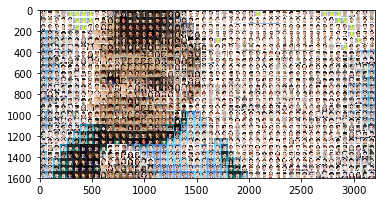

In [92]:
# plot image

solution = m.getAttr('x',p)
solution_basis = np.zeros((ncol,nrow))
a = np.arange(n_basis)
mosaic_image = np.zeros_like(target_image)

for i in range(ncol):
    for j in range(nrow):
        for b in range(n_basis):       
            a[b] = solution[i,j,b]
        solution_basis[i,j] = np.argmax(a)
        mosaic_image[basis_size*i:basis_size*(i+1),basis_size*j:basis_size*(j+1),:] = basis_images[np.argmax(a),:,:,:]
plt.imshow(mosaic_image)
plt.show()

In [96]:
# save image and solution

unique,counts= np.unique(solution_basis, return_counts=True)
with open(r'C:\Users\LG\Documents\교재\2017_2학기\optimization\mosaic_image_constr20.pkl', 'wb') as f:
    pickle.dump(dict(zip(unique,counts)), f)
    
io.imsave(r'C:\Users\LG\Documents\교재\2017_2학기\optimization\mosaic_image_constr20.jpg', mosaic_image)

### constraints 5 (each basis can be used at most 5 times)

In [98]:
c = 5 # maximum usage of each basis 
m = Model("mosaic")
p = m.addVars(int(ncol),int(nrow),int(n_basis),vtype=GRB.BINARY)
diff = m.addVars(int(ncol),int(nrow),3)

m.setObjective(diff.sum(), GRB.MINIMIZE)

m.addConstrs((p.sum(i,j,'*') == 1 for i in range(ncol) for j in range(nrow)), "sos")
m.addConstrs((diff[i,j,c] >= quicksum(p[i,j,b]*(basis_mean[b,c]-target_mean[i,j,c]) for b in range(n_basis))
              for i in range(ncol) for j in range(nrow) for c in range(3)), "diff1")
m.addConstrs((diff[i,j,c] >= -quicksum(p[i,j,b]*(basis_mean[b,c]-target_mean[i,j,c]) for b in range(n_basis))
              for i in range(ncol) for j in range(nrow) for c in range(3)), "diff2")
m.addConstrs((p.sum('*','*',b) <= c for b in range(n_basis)), "usage_constraint")

m.optimize()

Optimize a model with 9046 rows, 373750 columns and 2967498 nonzeros
Variable types: 3750 continuous, 370000 integer (370000 binary)
Coefficient statistics:
  Matrix range     [2e-04, 2e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 228866
Presolve removed 1416 rows and 708 columns
Presolve time: 4.63s
Presolved: 7630 rows, 373042 columns, 2528538 nonzeros
Variable types: 3042 continuous, 370000 integer (370000 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.271274e+03   0.000000e+00      5s
   22814    5.0953408e+04   1.023319e+04   0.000000e+00     10s
   34482    6.0353204e+04   8.553608e+04   0.000000e+00     15s
   54008    7.7211530e+04   6.499557e+03   0.000000e+00     20s
   70004    8.5344228e+04   1.578357e+04   0.000000e+00     25s
   83598    8.7827618e+04   1.003406e+04   0.000000e+00     30s
   97892   

   873   607 118482.658  406  268 118508.506 118426.282  0.07%  45.5 1249s
   922   642 118483.406  433  278 118508.506 118426.282  0.07%  44.0 1265s
   961   663 118483.980  453  270 118508.506 118426.282  0.07%  43.5 1283s
   983   677 118484.876  465  285 118508.506 118426.282  0.07%  43.2 1299s
  1012   689 118485.390  473  320 118508.506 118426.282  0.07%  42.7 1319s
  1038   706 118485.454  487  281 118508.506 118426.282  0.07%  42.6 1340s
  1060   714 118485.800  497  290 118508.506 118426.282  0.07%  42.6 1358s
  1096   734 118486.339  517  291 118508.506 118426.282  0.07%  41.7 1379s
  1155   764 118486.748  537  262 118508.506 118426.282  0.07%  40.6 1399s
  1259   840 118488.546  585  262 118508.506 118426.282  0.07%  39.1 1419s
  1329   900 118490.981  636  251 118508.506 118426.282  0.07%  38.3 1441s
  1399   953 118491.459  663  247 118508.506 118426.282  0.07%  37.5 1462s
  1460   992 118491.908  692  242 118508.506 118426.282  0.07%  36.5 1484s
  1541  1056 118497.772  

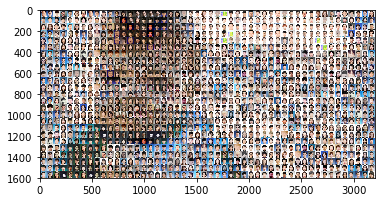

In [99]:
solution = m.getAttr('x',p)
solution_basis_5 = np.zeros((ncol,nrow))
mosaic_image_5 = np.zeros_like(target_image)
a = np.arange(n_basis)

for i in range(ncol):
    for j in range(nrow):
        for b in range(n_basis):       
            a[b] = solution[i,j,b]
        solution_basis_5[i,j] = np.argmax(a)
        mosaic_image_5[basis_size*i:basis_size*(i+1),basis_size*j:basis_size*(j+1),:] = basis_images[np.argmax(a),:,:,:]
plt.imshow(mosaic_image_5)
plt.show()

In [108]:
unique,counts= np.unique(solution_basis_5, return_counts=True)
with open(r'C:\Users\LG\Documents\교재\2017_2학기\optimization\mosaic_image_constr5.pkl', 'wb') as f:
    pickle.dump(dict(zip(unique,counts)), f)
    
io.imsave(r'C:\Users\LG\Documents\교재\2017_2학기\optimization\mosaic_image_constr5.jpg', mosaic_image_5)

### use celeb A 2000 images ( to use more basis image)
### constraint 1

basis image dimension : (64, 64, 3)
basis image number: 1997


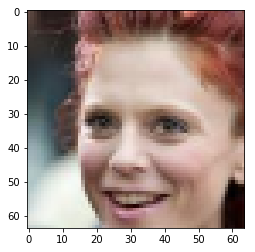

In [9]:
basis_images = []
basis_size = 64
f_jpg = glob.glob(os.path.join(r'C:\Users\LG\Documents\교재\2017_2학기\optimization\celelA', "*.jpg"))
for file in f_jpg:
    img = io.imread(file)[45:45+128,25:25+128,:]
    img = cv2.resize(img, (basis_size,basis_size), interpolation=cv2.INTER_AREA)
    basis_images.append(img)    
    
basis_images = np.array(basis_images)
print( "basis image dimension :", basis_images[0,:,:,:].shape)
print( "basis image number:", basis_images.shape[0])

plt.imshow(basis_images[1,:,:,:])
plt.show()

In [10]:
(ncol, nrow)=np.array(target_image.shape[:2])//basis_size
n_basis = basis_images.shape[0]
basis_mean = np.mean(basis_images, axis=(1,2))

target_mean= np.zeros((ncol, nrow,3))
for i in range(ncol):
    for j in range(nrow):
        target_mean[i,j,:]= np.mean(target_image[basis_size*i:basis_size*(i+1),basis_size*j:basis_size*(j+1),:], axis=(0,1))

In [11]:
c = 1 # maximum usage of each basis 

m = Model("mosaic")
p = m.addVars(int(ncol),int(nrow),int(n_basis),vtype=GRB.BINARY)
diff = m.addVars(int(ncol),int(nrow),3)

m.setObjective(diff.sum(), GRB.MINIMIZE)

m.addConstrs((p.sum(i,j,'*') == 1 for i in range(ncol) for j in range(nrow)), "sos")
m.addConstrs((diff[i,j,c] >= quicksum(p[i,j,b]*(basis_mean[b,c]-target_mean[i,j,c]) for b in range(n_basis))
              for i in range(ncol) for j in range(nrow) for c in range(3)), "diff1")
m.addConstrs((diff[i,j,c] >= -quicksum(p[i,j,b]*(basis_mean[b,c]-target_mean[i,j,c]) for b in range(n_basis))
              for i in range(ncol) for j in range(nrow) for c in range(3)), "diff2")
m.addConstrs((p.sum('*','*',b) <= c for b in range(n_basis)), "usage_constraint")

m.params.MIPGap = 0.01 # relax gap
m.optimize()

Changed value of parameter MIPGap to 0.01
   Prev: 0.0001  Min: 0.0  Max: 1e+100  Default: 0.0001
Optimize a model with 10747 rows, 2500000 columns and 19977484 nonzeros
Variable types: 3750 continuous, 2496250 integer (2496250 binary)
Coefficient statistics:
  Matrix range     [2e-04, 2e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 278387
Presolve removed 1698 rows and 849 columns (presolve time = 7s) ...
Presolve removed 1698 rows and 849 columns (presolve time = 10s) ...
Presolve removed 1698 rows and 849 columns (presolve time = 16s) ...
Presolve removed 1698 rows and 849 columns (presolve time = 40s) ...
Presolve removed 1698 rows and 849 columns
Presolve time: 44.42s
Presolved: 9049 rows, 2499151 columns, 16267972 nonzeros
Variable types: 2901 continuous, 2496250 integer (2496250 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    

  305060    1.8618092e+05   1.651060e+02   0.000000e+00    623s
  305182    1.8618102e+05   2.485976e+03   0.000000e+00    625s
  305426    1.8618111e+05   2.465846e+02   0.000000e+00    636s
  305548    1.8618111e+05   2.608939e+02   0.000000e+00    643s
  305670    1.8618111e+05   1.571218e+02   0.000000e+00    651s
  305804    1.8618111e+05   1.062577e+02   0.000000e+00    657s
  306061    1.8618190e+05   7.138151e+01   0.000000e+00    668s
  306183    1.8618190e+05   3.477814e+01   0.000000e+00    673s
  306305    1.8618190e+05   1.531621e+01   0.000000e+00    678s
  306427    1.8618190e+05   1.292584e+02   0.000000e+00    683s
  306557    1.8618198e+05   1.213006e+01   0.000000e+00    689s
  306679    1.8618198e+05   1.592193e+01   0.000000e+00    695s
  306806    1.8618203e+05   2.044723e+02   0.000000e+00    701s
  307210    1.8618205e+05   0.000000e+00   0.000000e+00    712s


Root relaxation: objective 1.861813e+05, 307210 iterations, 665.24 seconds
Total elapsed time = 986.21

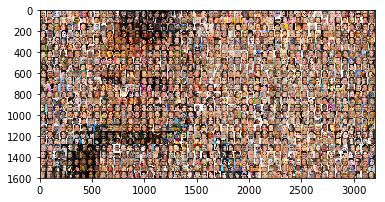

In [12]:
solution = m.getAttr('x',p)
solution_basis_1 = np.zeros((ncol,nrow))
mosaic_image_1 = np.zeros_like(target_image)
a = np.arange(n_basis)

for i in range(ncol):
    for j in range(nrow):
        for b in range(n_basis):       
            a[b] = solution[i,j,b]
        solution_basis_1[i,j] = np.argmax(a)
        mosaic_image_1[basis_size*i:basis_size*(i+1),basis_size*j:basis_size*(j+1),:] = basis_images[np.argmax(a),:,:,:]
plt.imshow(mosaic_image_1)
plt.show()

In [13]:
unique,counts= np.unique(solution_basis_1, return_counts=True)
with open(r'C:\Users\LG\Documents\교재\2017_2학기\optimization\mosaic_image_constr1_001.pkl', 'wb') as f:
    pickle.dump(dict(zip(unique,counts)), f)
    
io.imsave(r'C:\Users\LG\Documents\교재\2017_2학기\optimization\mosaic_image_constr1_001.jpg', mosaic_image_1)

### lower mip gap 0.001

In [14]:
c = 1 # maximum usage of each basis 

m = Model("mosaic")
p = m.addVars(int(ncol),int(nrow),int(n_basis),vtype=GRB.BINARY)
diff = m.addVars(int(ncol),int(nrow),3)

m.setObjective(diff.sum(), GRB.MINIMIZE)

m.addConstrs((p.sum(i,j,'*') == 1 for i in range(ncol) for j in range(nrow)), "sos")
m.addConstrs((diff[i,j,c] >= quicksum(p[i,j,b]*(basis_mean[b,c]-target_mean[i,j,c]) for b in range(n_basis))
              for i in range(ncol) for j in range(nrow) for c in range(3)), "diff1")
m.addConstrs((diff[i,j,c] >= -quicksum(p[i,j,b]*(basis_mean[b,c]-target_mean[i,j,c]) for b in range(n_basis))
              for i in range(ncol) for j in range(nrow) for c in range(3)), "diff2")
m.addConstrs((p.sum('*','*',b) <= c for b in range(n_basis)), "usage_constraint")

m.params.MIPGap = 0.001 # relax gap
m.optimize()

Changed value of parameter MIPGap to 0.001
   Prev: 0.0001  Min: 0.0  Max: 1e+100  Default: 0.0001
Optimize a model with 10747 rows, 2500000 columns and 19977484 nonzeros
Variable types: 3750 continuous, 2496250 integer (2496250 binary)
Coefficient statistics:
  Matrix range     [2e-04, 2e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 278387
Presolve removed 1698 rows and 849 columns (presolve time = 7s) ...
Presolve removed 1698 rows and 849 columns (presolve time = 10s) ...
Presolve removed 1698 rows and 849 columns (presolve time = 16s) ...
Presolve removed 1698 rows and 849 columns (presolve time = 20s) ...
Presolve removed 1698 rows and 849 columns (presolve time = 41s) ...
Presolve removed 1698 rows and 849 columns (presolve time = 45s) ...
Presolve removed 1698 rows and 849 columns
Presolve time: 45.46s
Presolved: 9049 rows, 2499151 columns, 16267972 nonzeros
Variable types: 2901 cont

  302646    1.8617501e+05   1.088123e+03   0.000000e+00    612s
  302961    1.8617501e+05   5.070078e+02   0.000000e+00    616s
  303389    1.8617502e+05   9.197144e+02   0.000000e+00    623s
  303511    1.8617502e+05   1.409425e+03   0.000000e+00    628s
  303633    1.8617502e+05   3.697611e+02   0.000000e+00    632s
  303755    1.8617502e+05   1.882880e+02   0.000000e+00    636s
  303877    1.8617502e+05   1.974236e+02   0.000000e+00    640s
  304159    1.8617623e+05   9.671604e+02   0.000000e+00    646s
  304281    1.8617633e+05   5.739306e+02   0.000000e+00    650s
  304586    1.8617712e+05   8.066029e+02   0.000000e+00    656s
  304927    1.8618041e+05   7.865552e+02   0.000000e+00    662s
  305182    1.8618102e+05   2.485976e+03   0.000000e+00    667s
  305426    1.8618111e+05   2.465846e+02   0.000000e+00    676s
  305548    1.8618111e+05   2.608939e+02   0.000000e+00    683s
  305670    1.8618111e+05   1.571218e+02   0.000000e+00    690s
  305804    1.8618111e+05   1.062577e+02

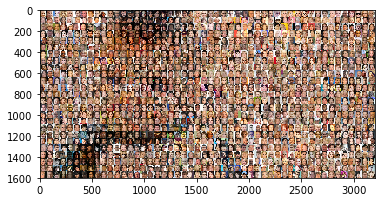

In [15]:
solution = m.getAttr('x',p)
solution_basis_1 = np.zeros((ncol,nrow))
mosaic_image_1 = np.zeros_like(target_image)
a = np.arange(n_basis)

for i in range(ncol):
    for j in range(nrow):
        for b in range(n_basis):       
            a[b] = solution[i,j,b]
        solution_basis_1[i,j] = np.argmax(a)
        mosaic_image_1[basis_size*i:basis_size*(i+1),basis_size*j:basis_size*(j+1),:] = basis_images[np.argmax(a),:,:,:]
plt.imshow(mosaic_image_1)
plt.show()

In [16]:
unique,counts= np.unique(solution_basis_1, return_counts=True)
with open(r'C:\Users\LG\Documents\교재\2017_2학기\optimization\mosaic_image_constr1_0001.pkl', 'wb') as f:
    pickle.dump(dict(zip(unique,counts)), f)
    
io.imsave(r'C:\Users\LG\Documents\교재\2017_2학기\optimization\mosaic_image_constr1_0001.jpg', mosaic_image_1)

### more tiles

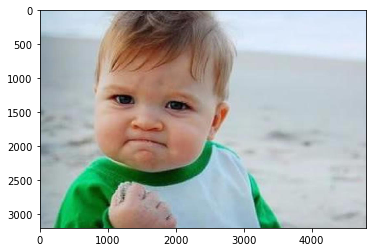

total tile number :  3750


In [2]:
target_image = io.imread(r'C:\Users\LG\Pictures\target_image.jpg')
target_image = cv2.resize(target_image, (5760,3200), interpolation=cv2.INTER_AREA)[:,:4800,:]
plt.imshow(target_image)
plt.show()

basis_size = 64
(ncol, nrow)=np.array(target_image.shape[:2])//basis_size
print("total tile number : ", ncol*nrow)

In [3]:
basis_images = []
f_jpg = glob.glob(os.path.join(r'C:\Users\LG\Documents\교재\2017_2학기\optimization\celelA', "*.jpg"))
for file in f_jpg[:2000]:
    img = io.imread(file)[45:45+128,25:25+128,:]
    img = cv2.resize(img, (basis_size,basis_size), interpolation=cv2.INTER_AREA)
    basis_images.append(img)    
    
basis_images = np.array(basis_images)
n_basis = basis_images.shape[0]
print( "basis image dimension :", basis_images[0,:,:,:].shape)
print( "basis image number:", n_basis)

basis image dimension : (64, 64, 3)
basis image number: 2000


In [4]:
basis_mean = np.mean(basis_images, axis=(1,2))

target_mean= np.zeros((ncol, nrow,3))
for i in range(ncol):
    for j in range(nrow):
        target_mean[i,j,:]= np.mean(target_image[basis_size*i:basis_size*(i+1),basis_size*j:basis_size*(j+1),:], axis=(0,1))

In [5]:
c = 5 # maximum usage of each basis 

m = Model("mosaic")
p = m.addVars(int(ncol),int(nrow),int(n_basis),vtype=GRB.BINARY)
diff = m.addVars(int(ncol),int(nrow),3)

m.setObjective(diff.sum(), GRB.MINIMIZE)

m.addConstrs((p.sum(i,j,'*') == 1 for i in range(ncol) for j in range(nrow)), "sos")
m.addConstrs((diff[i,j,c] >= quicksum(p[i,j,b]*(basis_mean[b,c]-target_mean[i,j,c]) for b in range(n_basis))
              for i in range(ncol) for j in range(nrow) for c in range(3)), "diff1")
m.addConstrs((diff[i,j,c] >= -quicksum(p[i,j,b]*(basis_mean[b,c]-target_mean[i,j,c]) for b in range(n_basis))
              for i in range(ncol) for j in range(nrow) for c in range(3)), "diff2")
m.addConstrs((p.sum('*','*',b) <= c for b in range(n_basis)), "usage_constraint")

m.params.MIPGap = 0.01 # relax gap
m.optimize()

Changed value of parameter MIPGap to 0.01
   Prev: 0.0001  Min: 0.0  Max: 1e+100  Default: 0.0001
Optimize a model with 28250 rows, 7511250 columns and 60022464 nonzeros
Variable types: 11250 continuous, 7500000 integer (7500000 binary)
Coefficient statistics:
  Matrix range     [2e-04, 2e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 814042
Presolve removed 0 rows and 0 columns (presolve time = 10s) ...
Presolve removed 5226 rows and 2613 columns (presolve time = 16s) ...
Presolve removed 5226 rows and 2613 columns (presolve time = 28s) ...
Presolve removed 5226 rows and 2613 columns (presolve time = 30s) ...
Presolve removed 5226 rows and 2613 columns (presolve time = 35s) ...
Presolve removed 5226 rows and 2613 columns (presolve time = 40s) ...
Presolve removed 5226 rows and 2613 columns (presolve time = 45s) ...
Presolve removed 5226 rows and 2613 columns (presolve time = 54s) ...
Presol

  252013    3.9035337e+05   1.323354e+05   0.000000e+00    686s
  255160    3.9084571e+05   1.923127e+05   0.000000e+00    691s
  258322    3.9093455e+05   1.270258e+05   0.000000e+00    696s
  261606    3.9153185e+05   7.847404e+04   0.000000e+00    701s
  264077    3.9211641e+05   7.650045e+04   0.000000e+00    706s
  266000    3.9246441e+05   9.531867e+04   0.000000e+00    711s
  270090    3.9337126e+05   1.132150e+05   0.000000e+00    716s
  273901    3.9339774e+05   8.611274e+05   0.000000e+00    720s
  277326    3.9616902e+05   1.356936e+05   0.000000e+00    725s
  280638    3.9835524e+05   2.784238e+05   0.000000e+00    731s
  285433    4.0018760e+05   2.989373e+05   0.000000e+00    736s
  288858    4.0029975e+05   2.434748e+05   0.000000e+00    742s
  291524    4.0043739e+05   2.776003e+05   0.000000e+00    746s
  294210    4.0068705e+05   2.955453e+05   0.000000e+00    750s
  299576    4.0107704e+05   9.105691e+04   0.000000e+00    755s
  304154    4.0111298e+05   5.446683e+04

  582996    4.2747185e+05   4.243066e+03   0.000000e+00   1347s
  583966    4.2752966e+05   6.385075e+03   0.000000e+00   1352s
  584978    4.2753859e+05   3.669798e+03   0.000000e+00   1357s
  585691    4.2754678e+05   3.200079e+03   0.000000e+00   1360s
  586703    4.2759298e+05   3.821876e+03   0.000000e+00   1368s
  587253    4.2763833e+05   3.978596e+03   0.000000e+00   1370s
  587716    4.2778550e+05   4.638270e+03   0.000000e+00   1380s
  588357    4.2786142e+05   4.303434e+03   0.000000e+00   1382s
  589704    4.2789552e+05   3.234986e+03   0.000000e+00   1388s
  590151    4.2794509e+05   3.249441e+03   0.000000e+00   1390s
  590688    4.2795931e+05   2.525246e+03   0.000000e+00   1395s
  591512    4.2797077e+05   2.512669e+03   0.000000e+00   1401s
  592619    4.2798698e+05   1.412414e+04   0.000000e+00   1405s
  593294    4.2799610e+05   3.006121e+03   0.000000e+00   1419s
  593578    4.2800039e+05   1.918588e+03   0.000000e+00   1425s
  594456    4.2801678e+05   1.863420e+03

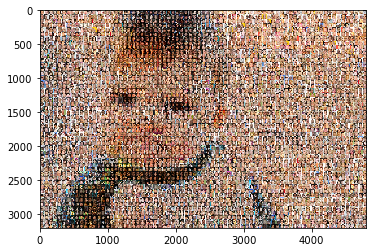

In [6]:
solution = m.getAttr('x',p)
solution_basis_big_5 = np.zeros((ncol,nrow))
mosaic_image_big_5 = np.zeros_like(target_image)
a = np.arange(n_basis)

for i in range(ncol):
    for j in range(nrow):
        for b in range(n_basis):       
            a[b] = solution[i,j,b]
        solution_basis_big_5[i,j] = np.argmax(a)
        mosaic_image_big_5[basis_size*i:basis_size*(i+1),basis_size*j:basis_size*(j+1),:] = basis_images[np.argmax(a),:,:,:]
plt.imshow(mosaic_image_big_5)
plt.show()

In [7]:
unique,counts= np.unique(solution_basis_big_5, return_counts=True)
with open(r'C:\Users\LG\Documents\교재\2017_2학기\optimization\mosaic_image_constr5_big_001.pkl', 'wb') as f:
    pickle.dump(dict(zip(unique,counts)), f)
    
io.imsave(r'C:\Users\LG\Documents\교재\2017_2학기\optimization\mosaic_image_constr5_big_001.jpg', mosaic_image_big_5)